In [8]:
import pandas as pd
import pyodbc
import os # Used for getting environment variables for credentials

# --- Load Column Metadata ---
# The script expects the CSV file to be in a 'data' subdirectory.
# Adjust the path if necessary.
csv_filename = 'data/COLUMNS_202510131556.csv'

try:
    columns_df = pd.read_csv(csv_filename)
    print(f"Successfully loaded metadata for {len(columns_df)} columns from '{csv_filename}'.\n")
except FileNotFoundError:
    print(f"Error: The file '{csv_filename}' was not found.")
    print("Please make sure the file exists and the path is correct.")
    exit()
# --- Connection Details --- 
server = '172.22.74.254'
database = 'aws_stage'
username = 'extmertcan.coskun'
password = 'id3bGWpkLeDea4EAE4W9'
table_name = 'raw__hr_kpi_t_sf_newsf_employees'
schema_name = 'sf_odata' 

# Construct the connection string
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};' 
    f'SERVER={server};' 
    f'DATABASE={database};' 
    f'UID={username};' 
    f'PWD={password};' 
    f'Encrypt=yes;' 
    f'TrustServerCertificate=yes;'
)

# Establish connection
try:
    cnxn = pyodbc.connect(conn_str)
    cursor = cnxn.cursor()
    print("Connection to database established successfully!")
        
    # --- Main Analysis Loop ---
    # Group columns by table to process one table at a time
    grouped_by_table = columns_df.groupby('TABLE_NAME')

    # Iterate over each table defined in the CSV
    for table_name, group in grouped_by_table:
        print("─" * 80)
        print(f"Processing Table: {schema_name}.{table_name}")
        print("─" * 80)

        try:
            # 1. Fetch data from the database for the current table
            query = f'SELECT * FROM "{schema_name}"."{table_name}"'
            print(f"Loading data from {table_name}...")
            df = pd.read_sql(query, cnxn)
            print(f"Data loaded successfully with {len(df)} rows.\n")

            # 2. Perform Null or Empty Value Checks
            print("--- Checking for Null or Empty Values ---")
            table_columns = group['COLUMN_NAME'].tolist()
            for col in table_columns:
                if col in df.columns:
                    # Count both None/NaN and empty strings ''
                    null_count = df[col].isnull().sum()
                    empty_count = (df[col].astype(str) == '').sum()
                    total_invalid = null_count + empty_count
                    if total_invalid > 0:
                        percentage = (total_invalid / len(df)) * 100
                        print(f"  - Column '{col}': {total_invalid} null/empty values ({percentage:.2f}%)")
                    else:
                        print(f"  - Column '{col}': OK (0 null/empty values)")
                else:
                    print(f"  - WARNING: Column '{col}' not found in the table.")
            
            print("\n--- Checking for Language Mismatches (Distinct Counts) ---")
            # 3. Perform Language Mismatch Checks
            
            # Create a base column name for pairing (e.g., 'status_tr' -> 'status')
            group['base_column_name'] = group['COLUMN_NAME'].str.replace('_tr$', '', regex=True).str.replace('_en$', '', regex=True)
            
            # Find pairs within the current table group
            paired_columns = group.groupby('base_column_name').filter(lambda x: len(x) == 2)
            
            if not paired_columns.empty:
                for base_name, pair in paired_columns.groupby('base_column_name'):
                    col_tr = f"{base_name}_tr"
                    col_en = f"{base_name}_en"
                    
                    if col_tr in df.columns and col_en in df.columns:
                        distinct_tr = df[col_tr].nunique()
                        distinct_en = df[col_en].nunique()
                        
                        if distinct_tr != distinct_en:
                            print(f"  - MISMATCH in '{base_name}': TR count = {distinct_tr}, EN count = {distinct_en}")
                        else:
                            print(f"  - OK for '{base_name}': TR and EN counts are both {distinct_tr}")
                    else:
                        print(f"  - SKIPPING check for '{base_name}': One or both columns not found in the table.")
            else:
                print("  No English/Turkish column pairs found for this table in the metadata file.")

        except Exception as e:
            print(f"\nAn error occurred while processing table {table_name}: {e}")
        
        print("\n") # Add space before processing the next table

except Exception as e:
    print(f"Failed to connect to the database. Error: {e}")

Successfully loaded metadata for 131 columns from 'data/COLUMNS_202510131556.csv'.

Connection to database established successfully!
────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_job_application_education_newsf_rmore
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_job_application_education_newsf_rmore...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 8656 rows.

--- Checking for Null or Empty Values ---
  - Column 'country_tr': OK (0 null/empty values)
  - Column 'country_en': OK (0 null/empty values)
  - Column 'graduation_tr': OK (0 null/empty values)
  - Column 'graduation_en': OK (0 null/empty values)
  - Column 'name_of_school_tr': OK (0 null/empty values)
  - Column 'name_of_school_en': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  - OK for 'country': TR and EN counts are both 47
  - MISMATCH in 'graduation': TR count = 2, EN count = 4
  - MISMATCH in 'name_of_school': TR count = 274, EN count = 275


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_job_application_languages_newsf_rmore
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_job_application_languages_newsf_rmore...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 6634 rows.

--- Checking for Null or Empty Values ---
  - Column 'language_tr': OK (0 null/empty values)
  - Column 'language_en': OK (0 null/empty values)
  - Column 'writing_tr': OK (0 null/empty values)
  - Column 'writing_en': OK (0 null/empty values)
  - Column 'reading_tr': OK (0 null/empty values)
  - Column 'reading_en': OK (0 null/empty values)
  - Column 'speaking_tr': OK (0 null/empty values)
  - Column 'speaking_en': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  - OK for 'language': TR and EN counts are both 41
  - OK for 'reading': TR and EN counts are both 5
  - OK for 'speaking': TR and EN counts are both 5
  - OK for 'writing': TR and EN counts are both 5


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_job_applications_newsf_rmore
────────────────────────────────────────────────────────────────────────────────
Loading data

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 19878 rows.

--- Checking for Null or Empty Values ---
  - Column 'teklif_retnedenleri_tr': OK (0 null/empty values)
  - Column 'teklif_retnedenleri_en': OK (0 null/empty values)
  - Column 'onr_departman_tr': OK (0 null/empty values)
  - Column 'onr_departman_en': OK (0 null/empty values)
  - Column 'oneren_yetkili_tr': OK (0 null/empty values)
  - Column 'oneren_yetkili_en': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_tr': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_en': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_tr': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_en': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_iki_tr': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_iki_en': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_uc_tr': OK (0 null/empty values)
  - Column 'gorusen_kisi_ik_ygf_uc_en': OK (0 null/empty values)
  - Column 'durum_tr': OK (0 null/empty values)
  - Column 'dur

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 12490 rows.

--- Checking for Null or Empty Values ---
  - Column 'assigned_item_name_tr': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  No English/Turkish column pairs found for this table in the metadata file.


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_employee_education
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_employee_education...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 3618 rows.

--- Checking for Null or Empty Values ---
  - Column 'country_tr': OK (0 null/empty values)
  - Column 'country_en': OK (0 null/empty values)
  - Column 'graduation_tr': OK (0 null/empty values)
  - Column 'graduation_en': OK (0 null/empty values)
  - Column 'level_of_education_name_tr': OK (0 null/empty values)
  - Column 'level_of_education_name_en': OK (0 null/empty values)
  - Column 'name_of_school_tr': OK (0 null/empty values)
  - Column 'name_of_school_en': OK (0 null/empty values)
  - Column 'field_of_study_tr': OK (0 null/empty values)
  - Column 'field_of_study_en': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  - OK for 'country': TR and EN counts are both 36
  - MISMATCH in 'field_of_study': TR count = 325, EN count = 328
  - MISMATCH in 'graduation': TR count = 2, EN count = 4
  - OK for 'level_of_education_name': TR and EN counts are both 6
  - MISMATCH in 'name_of_school': TR count = 231, E

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 7838 rows.

--- Checking for Null or Empty Values ---
  - Column 'employee_status_tr': OK (0 null/empty values)
  - Column 'employee_status_en': OK (0 null/empty values)
  - Column 'ronesans_rank_tr': OK (0 null/empty values)
  - Column 'ronesans_rank_en': OK (0 null/empty values)
  - Column 'ronesans_rank_personal_tr': OK (0 null/empty values)
  - Column 'ronesans_rank_personal_en': OK (0 null/empty values)
  - Column 'workplace_tr': OK (0 null/empty values)
  - Column 'workplace_en': OK (0 null/empty values)
  - Column 'employee_area_en': OK (0 null/empty values)
  - Column 'employee_group_tr': OK (0 null/empty values)
  - Column 'employee_group_en': OK (0 null/empty values)
  - Column 'employee_sub_group_tr': OK (0 null/empty values)
  - Column 'employee_sub_group_en': OK (0 null/empty values)
  - Column 'work_area_tr': OK (0 null/empty values)
  - Column 'work_area_en': OK (0 null/empty values)
  - Column 'real_termination_reason_tr': OK (0 null/empty 

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 19358 rows.

--- Checking for Null or Empty Values ---
  - Column 'employee_status_tr': OK (0 null/empty values)
  - Column 'employee_status_en': OK (0 null/empty values)
  - Column 'ronesans_rank_tr': OK (0 null/empty values)
  - Column 'ronesans_rank_en': OK (0 null/empty values)
  - Column 'ronesans_rank_personal_tr': OK (0 null/empty values)
  - Column 'ronesans_rank_personal_en': OK (0 null/empty values)
  - Column 'workplace_tr': OK (0 null/empty values)
  - Column 'workplace_en': OK (0 null/empty values)
  - Column 'employee_area_en': OK (0 null/empty values)
  - Column 'employee_group_tr': OK (0 null/empty values)
  - Column 'employee_group_en': OK (0 null/empty values)
  - Column 'employee_sub_group_tr': OK (0 null/empty values)
  - Column 'employee_sub_group_en': OK (0 null/empty values)
  - Column 'work_area_tr': OK (0 null/empty values)
  - Column 'work_area_en': OK (0 null/empty values)
  - Column 'real_termination_reason_tr': OK (0 null/empty

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 81 rows.

--- Checking for Null or Empty Values ---
  - Column 'name_tr': 16 null/empty values (19.75%)
  - Column 'name_en': 1 null/empty values (1.23%)

--- Checking for Language Mismatches (Distinct Counts) ---
  - MISMATCH in 'name': TR count = 66, EN count = 80


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_languages
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_languages...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 2724 rows.

--- Checking for Null or Empty Values ---
  - Column 'language_tr': OK (0 null/empty values)
  - Column 'language_en': OK (0 null/empty values)
  - Column 'writing_tr': OK (0 null/empty values)
  - Column 'writing_en': OK (0 null/empty values)
  - Column 'reading_tr': OK (0 null/empty values)
  - Column 'reading_en': OK (0 null/empty values)
  - Column 'speaking_tr': OK (0 null/empty values)
  - Column 'speaking_en': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  - OK for 'language': TR and EN counts are both 38
  - OK for 'reading': TR and EN counts are both 5
  - OK for 'speaking': TR and EN counts are both 5
  - OK for 'writing': TR and EN counts are both 5


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_level_a
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_k

C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)
C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 148 rows.

--- Checking for Null or Empty Values ---
  - Column 'name_tr': OK (0 null/empty values)
  - Column 'name_en': 4 null/empty values (2.70%)

--- Checking for Language Mismatches (Distinct Counts) ---
  - MISMATCH in 'name': TR count = 104, EN count = 105


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_level_c
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_level_c...
Data loaded successfully with 626 rows.

--- Checking for Null or Empty Values ---
  - Column 'name_tr': OK (0 null/empty values)
  - Column 'name_en': 28 null/empty values (4.47%)

--- Checking for Language Mismatches (Distinct Counts) ---


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


  - MISMATCH in 'name': TR count = 241, EN count = 252


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_level_d
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_level_d...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 634 rows.

--- Checking for Null or Empty Values ---
  - Column 'name_tr': 2 null/empty values (0.32%)
  - Column 'name_en': 45 null/empty values (7.10%)

--- Checking for Language Mismatches (Distinct Counts) ---
  - MISMATCH in 'name': TR count = 310, EN count = 326


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_level_e
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_level_e...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 1165 rows.

--- Checking for Null or Empty Values ---
  - Column 'name_tr': 8 null/empty values (0.69%)
  - Column 'name_en': 65 null/empty values (5.58%)

--- Checking for Language Mismatches (Distinct Counts) ---
  - MISMATCH in 'name': TR count = 282, EN count = 279


────────────────────────────────────────────────────────────────────────────────
Processing Table: sf_odata.raw__hr_kpi_t_sf_newsf_perperson
────────────────────────────────────────────────────────────────────────────────
Loading data from raw__hr_kpi_t_sf_newsf_perperson...


C:\Users\mertc\AppData\Local\Temp\ipykernel_15596\3224062640.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 9854 rows.

--- Checking for Null or Empty Values ---
  - Column 'marital_status_tr': OK (0 null/empty values)
  - Column 'marital_status_en': OK (0 null/empty values)
  - Column 'native_preferred_language_tr': OK (0 null/empty values)
  - Column 'native_preferred_language_en': OK (0 null/empty values)

--- Checking for Language Mismatches (Distinct Counts) ---
  - OK for 'marital_status': TR and EN counts are both 3
  - OK for 'native_preferred_language': TR and EN counts are both 12




2025-10-21 10:02:58,664 - INFO - Attempting to load environment variables from .env file...
2025-10-21 10:02:58,665 - INFO - All database credentials have been loaded successfully.
2025-10-21 10:02:59,856 - INFO - Successfully connected to database 'aws_stage' on server '172.22.74.254'.
2025-10-21 10:02:59,856 - INFO - Executing query: SELECT "employee_status_en", "employee_type_name_en", "sap_id", "a_level_code", "date_of_birth", "job_end_date" FROM sf_odata.raw__hr_kpi_t_sf_newsf_employees
C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:95: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
2025-10-21 10:03:03,180 - INFO - Successfully fetched 7977 rows and 6 columns.
C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `


Analysis for column: 'employee_status_en'
Value Counts:
              Value  Count
0            Active   4378
1        Terminated   3587
2  Reported No Show     12


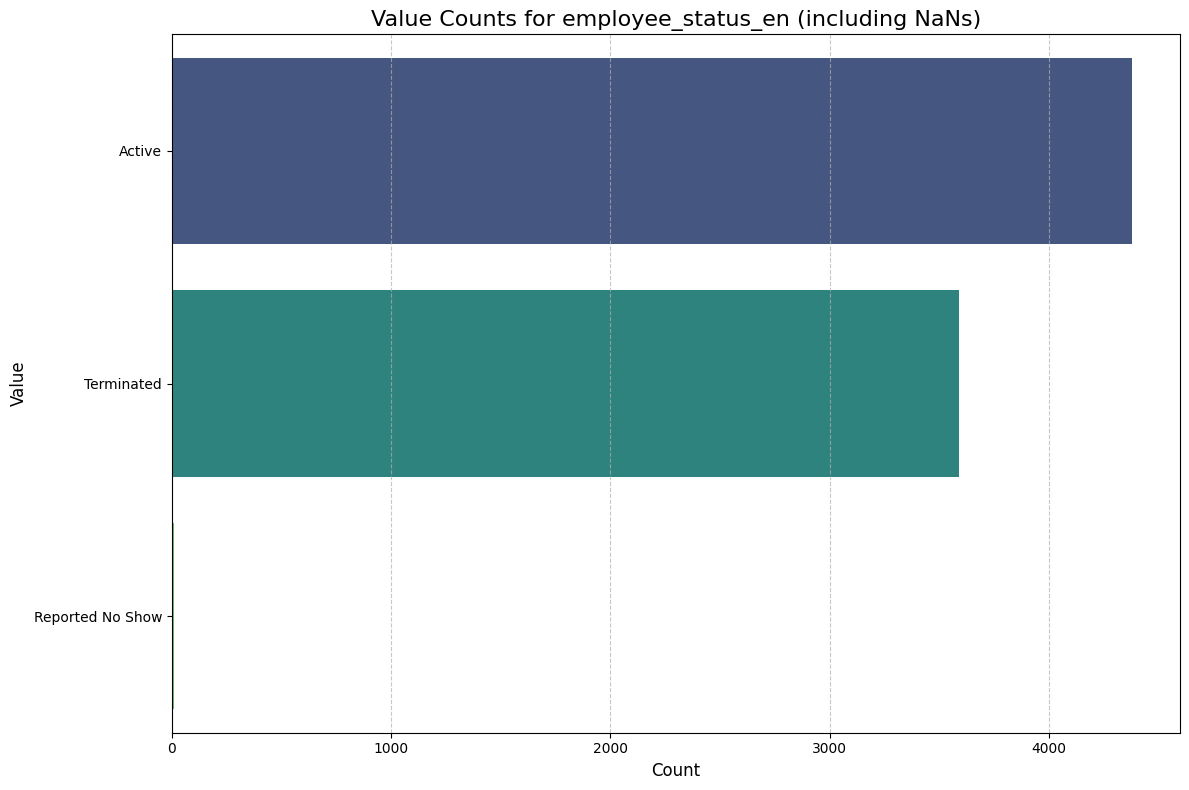

C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')



Analysis for column: 'employee_type_name_en'
Value Counts:
          Value  Count
0        Normal   6520
1        Pusula    484
2       Stajyer    364
3  Pusula Kadro    332
4           EYT    138
5    Ghost User    121
6   Oryantasyon     17
7          None      1


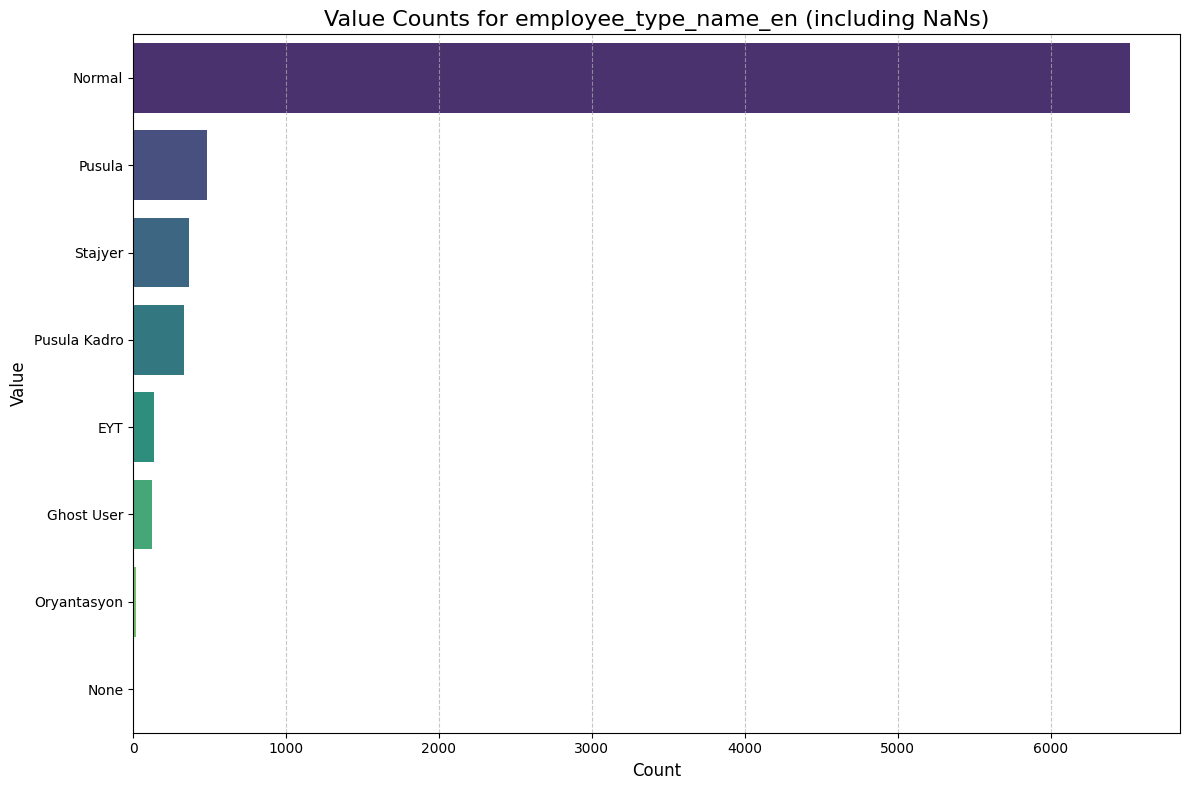

2025-10-21 10:03:03,596 - WARNING - Column 'sap_id' has 7973 unique values. Visualizing top 20 only.



Analysis for column: 'sap_id'
Value Counts:
         Value  Count
0                   3
1     47010140      2
2     47067811      2
3     47045320      1
4     47047553      1
...        ...    ...
7968  47062679      1
7969  47068398      1
7970  47066131      1
7971  47063264      1
7972  47062180      1

[7973 rows x 2 columns]


C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')


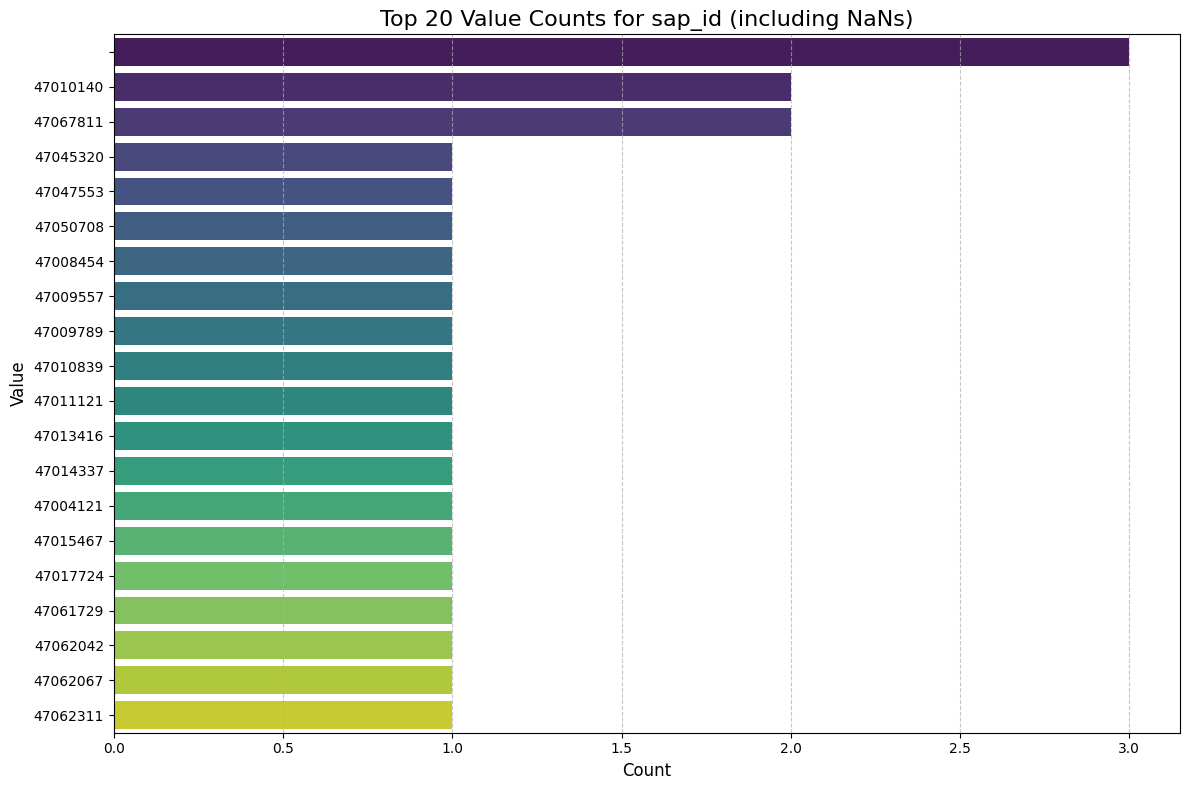

2025-10-21 10:03:03,823 - WARNING - Column 'a_level_code' has 26 unique values. Visualizing top 20 only.
2025-10-21 10:03:03,843 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')
2025-10-21 10:03:03,848 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Analysis for column: 'a_level_code'
Value Counts:
       Value  Count
0   10005415   2773
1   10004716    985
2   10005747    686
3   10004717    496
4   10003910    486
5   10005746    476
6   10003919    360
7   10002975    272
8   10005084    223
9   10000483    192
10  10000386    174
11  10002680    157
12  10000677    127
13  10005026    112
14  10004778     85
15  10003557     71
16  10002413     71
17  10003162     64
18  10000437     38
19  10005745     31
20  10000518     27
21  10002899     21
22  10002765     20
23  10004540     18
24  10002874     11
25                1


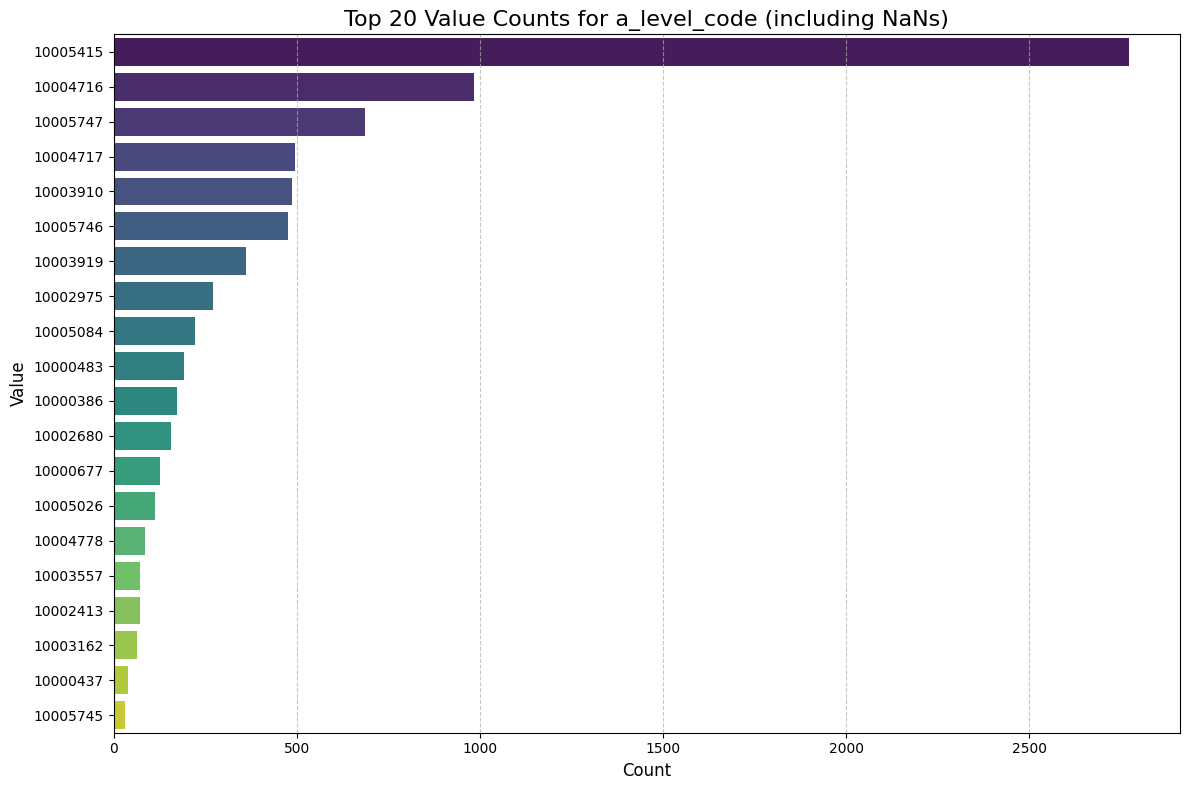

2025-10-21 10:03:04,076 - WARNING - Column 'date_of_birth' has 5521 unique values. Visualizing top 20 only.
2025-10-21 10:03:04,084 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')
2025-10-21 10:03:04,090 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Analysis for column: 'date_of_birth'
Value Counts:
          Value  Count
0    2000-01-01     22
1    1980-01-01     18
2    1999-01-01     16
3    2001-01-01     14
4    1995-01-01     11
...         ...    ...
5516 1981-08-25      1
5517 1998-09-13      1
5518 1981-08-31      1
5519 2001-10-07      1
5520 1978-04-16      1

[5521 rows x 2 columns]


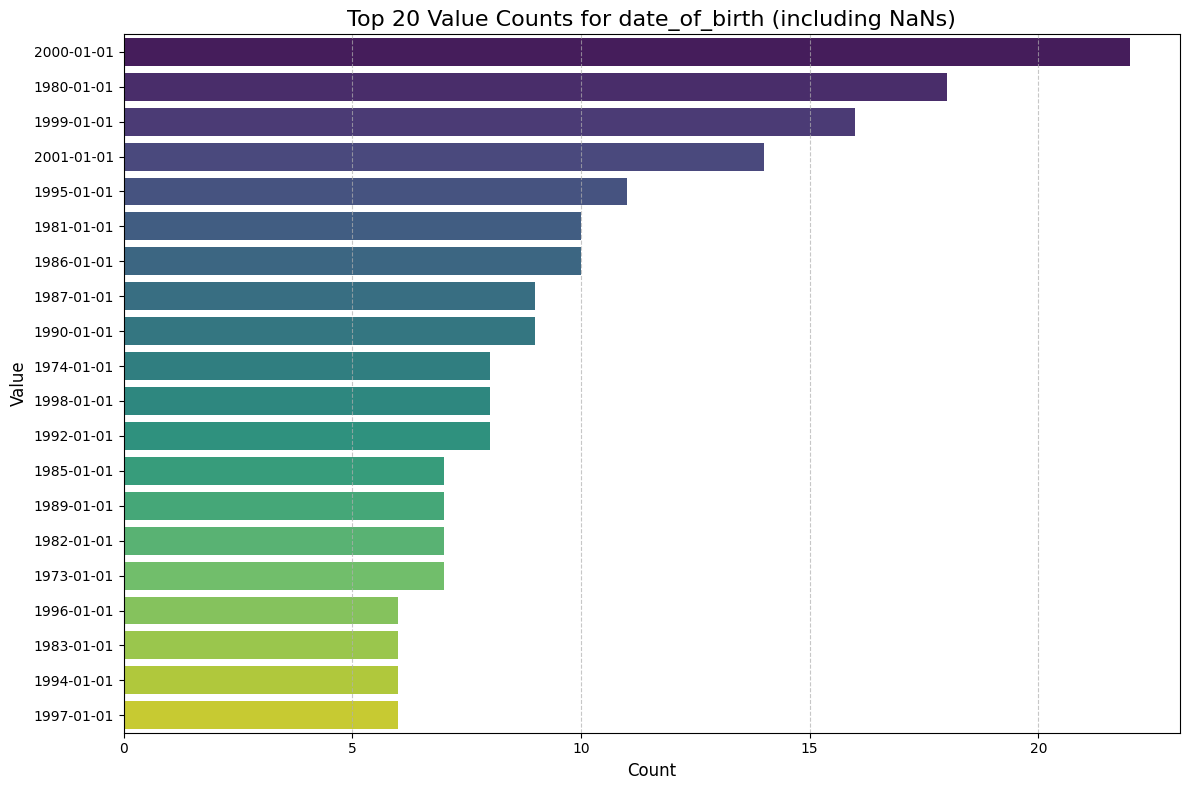

2025-10-21 10:03:04,345 - WARNING - Column 'job_end_date' has 136 unique values. Visualizing top 20 only.
2025-10-21 10:03:04,356 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\mertc\AppData\Local\Temp\ipykernel_15372\1581021257.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')
2025-10-21 10:03:04,360 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Analysis for column: 'job_end_date'
Value Counts:
         Value  Count
0   1753-01-01   4378
1   2025-07-01   2765
2   2025-08-15     43
3   2025-06-30     37
4   2025-08-29     30
..         ...    ...
131 2025-06-24      1
132 2025-10-04      1
133 2025-08-24      1
134 2025-10-14      1
135 2025-10-11      1

[136 rows x 2 columns]


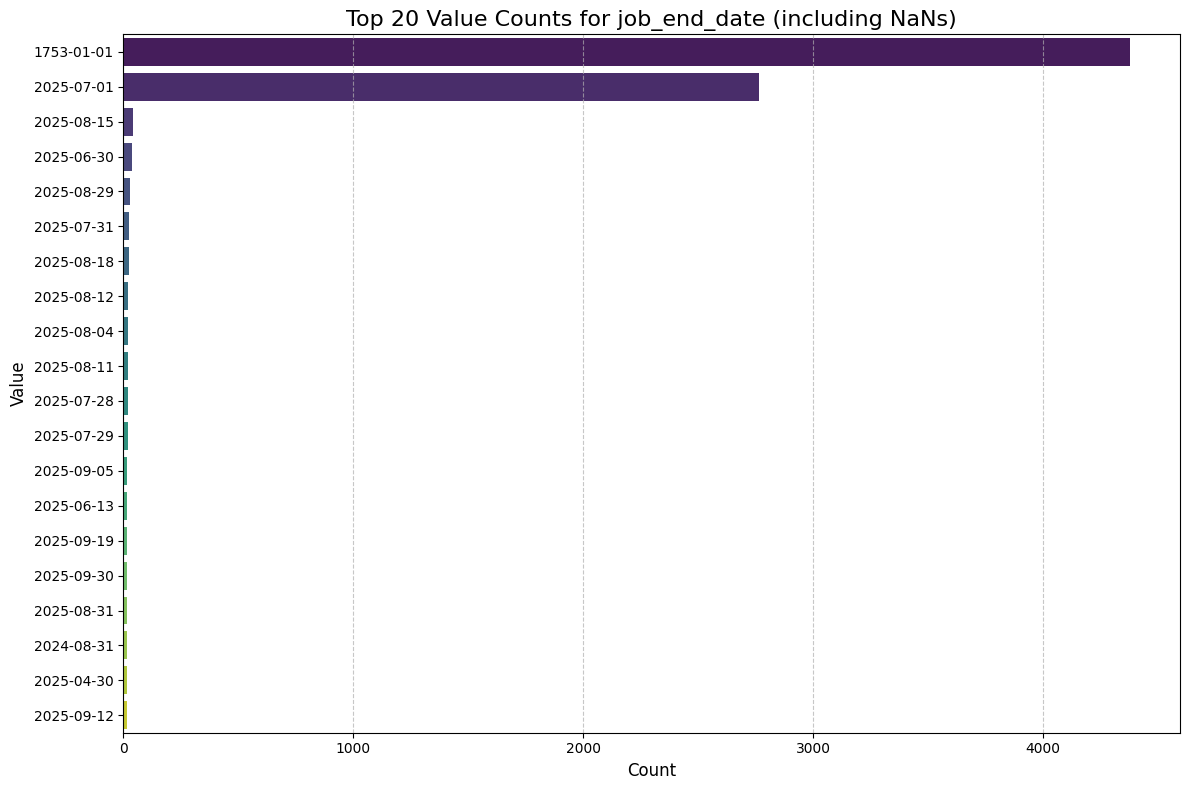

2025-10-21 10:03:04,800 - INFO - Database connection closed.


In [1]:
import pandas as pd
import pyodbc
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# --- Configure Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Load Environment Variables ---
# This will load variables from a .env file in the same directory as the script
load_dotenv()
logging.info("Attempting to load environment variables from .env file...")
# --- Connection Details --- 
server = '172.22.74.254'
database = 'aws_stage'
username = 'extmertcan.coskun'
password = 'id3bGWpkLeDea4EAE4W9'
table_name = 'raw__hr_kpi_t_sf_newsf_employees'
schema_name = 'sf_odata' 

# Construct the connection string
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};' 
    f'SERVER={server};' 
    f'DATABASE={database};' 
    f'UID={username};' 
    f'PWD={password};' 
    f'Encrypt=yes;' 
    f'TrustServerCertificate=yes;'
)
table_name = "raw__hr_kpi_t_sf_newsf_employees"
columns_to_analyze = [
    'employee_status_en',
    'employee_type_name_en',
    'sap_id',
    'a_level_code',
    'date_of_birth',
    'job_end_date',
]

def validate_credentials():
    """Checks if all necessary environment variables have been loaded."""
    credentials = {
        "DB_SERVER": server,
        "DB_DATABASE": database,
        "DB_USERNAME": username,
        "DB_PASSWORD": password
    }
    missing_vars = [key for key, value in credentials.items() if not value]
    
    if missing_vars:
        logging.error("="*50)
        logging.error("ERROR: Missing database credentials.")
        logging.error(f"The following environment variables are missing or empty in your .env file: {', '.join(missing_vars)}")
        logging.error("Please check your .env file and ensure all variables are set correctly.")
        logging.error("="*50)
        return False
    
    logging.info("All database credentials have been loaded successfully.")
    return True


def create_db_connection():
    """Establishes and returns a connection to the SQL Server database."""
    conn_str = (
        f'DRIVER={{ODBC Driver 17 for SQL Server}};' 
        f'SERVER={server};' 
        f'DATABASE={database};' 
        f'UID={username};' 
        f'PWD={password};' 
        f'Encrypt=yes;' 
        f'TrustServerCertificate=yes;'
    )
    try:
        conn = pyodbc.connect(conn_str)
        logging.info(f"Successfully connected to database '{database}' on server '{server}'.")
        return conn
    except pyodbc.Error as ex:
        sqlstate = ex.args[0]
        logging.error(f"Database connection failed. SQLSTATE: {sqlstate}")
        logging.error("This can be due to incorrect credentials, firewall rules, or network issues.")
        logging.error(ex)
        return None

def fetch_data(conn, schema: str, table: str, columns: list) -> pd.DataFrame:
    """Fetches specified columns from a table and returns a pandas DataFrame."""
    safe_columns = [f'"{col}"' for col in columns]
    query = f"SELECT {', '.join(safe_columns)} FROM {schema}.{table}"
    
    logging.info(f"Executing query: {query}")
    try:
        df = pd.read_sql(query, conn)
        logging.info(f"Successfully fetched {len(df)} rows and {len(df.columns)} columns.")
        return df
    except Exception as e:
        logging.error(f"Failed to execute query and fetch data: {e}")
        return pd.DataFrame()

def analyze_and_visualize(df: pd.DataFrame):
    """Calculates and visualizes value counts for each column in the DataFrame."""
    if df.empty:
        logging.warning("Input DataFrame is empty. Skipping analysis.")
        return
        
    for column in df.columns:
        print("\n" + "="*50)
        print(f"Analysis for column: '{column}'")
        print("="*50)

        value_counts = df[column].value_counts(dropna=False).reset_index()
        value_counts.columns = ['Value', 'Count']
        value_counts['Value'] = value_counts['Value'].fillna('NaN (Missing)')

        print("Value Counts:")
        print(value_counts)

        top_n = 20
        if len(value_counts) > top_n:
            logging.warning(f"Column '{column}' has {len(value_counts)} unique values. Visualizing top {top_n} only.")
            plot_data = value_counts.head(top_n)
            title = f'Top {top_n} Value Counts for {column} (including NaNs)'
        else:
            plot_data = value_counts
            title = f'Value Counts for {column} (including NaNs)'

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Count', y='Value', data=plot_data, palette='viridis', orient='h')
        
        plt.title(title, fontsize=16)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def main():
    """Main function to orchestrate the data profiling process."""
    # STEP 1: Validate credentials before trying to connect
    if not validate_credentials():
        return # Stop execution if credentials are not valid

    # STEP 2: Proceed with connection
    conn = create_db_connection()
    if conn:
        try:
            data_df = fetch_data(conn, schema_name, table_name, columns_to_analyze)
            analyze_and_visualize(data_df)
        finally:
            conn.close()
            logging.info("Database connection closed.")

if __name__ == "__main__":
    main()

